# Feature selection with Random Forests



## Introduction

- RandomForest Classifiers we used for feature selection. 
- Mean imputing and one-hot-encoding for categorical variables were used in data preprocessing
- GridSearchCV was selected for hyperparameter tuning, and the parameters which were fine-tuned were n_estimators (Number of trees in the forest) and max_depth (maximum depth of decision tree)

## Load Libraries
------


In [3]:
# Data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from scipy.stats import randint
from sklearn.inspection import permutation_importance
from random import randint 

## Data loading and preprocessing

---

In [4]:
# set the directory 
os.chdir('/Users/ecompu/Library/CloudStorage/OneDrive-Personal/Berkeley/W207_Machine_Learning/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/icr-identify-age-related-conditions/')

# load the dataset. It's called "train" because it comes form a Kaggle competition
dataset = pd.read_csv('train.csv')

In [5]:
# Change label to integer
label = "Class"

classes = dataset[label].unique().tolist()
print(f"Label classes: {classes}")

dataset[label] = dataset[label].map(classes.index)

Label classes: [1, 0]


In [6]:
# convert EJ to dummy 
ej_dummy = pd.get_dummies(
    dataset['EJ'],prefix='EJ', dtype=int)

dataset = pd.concat(
    [dataset,ej_dummy],
    axis=1
)

#drop ID and EJ
dataset = dataset.drop(['Id','EJ'], axis=1)

In [7]:
# outcome 
y = dataset['Class'].values

# features 
X = dataset[[i for i in dataset.columns if i not in ['Class']]].values

# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,
                                   test_size=0.20, random_state=42)

# train and test dataframes 
train_df = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

test_df = pd.concat(
    [pd.DataFrame(y_test), pd.DataFrame(X_test)],
    axis=1
)

# rename columns
train_df.columns=['Class','AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC',
                  'BD ', 'BN', 'BP','BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF',
                  'CH', 'CL', 'CR', 'CS', 'CU','CW ', 'DA', 'DE', 'DF', 'DH',
                  'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH',
                  'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR','FS',
                  'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'EJ_A', 'EJ_B']

# assign names to test_df
test_df.columns = train_df.columns

In [8]:
# Find which columns have missing values
sum_null = train_df.isnull().sum()
sum_null[sum_null!=0]


BQ    53
CC     1
DU     1
EL    52
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [9]:
# mean imputing on training set 
mean_values = train_df.mean()
filled_df = train_df.fillna(mean_values, inplace=False)
train_df = filled_df

sum_null = train_df.isnull().sum()
sum_null[sum_null!=0]

Series([], dtype: int64)

In [10]:
# mean imputing on test set with values from train set
mean_values = train_df.mean()
filled_df = test_df.fillna(mean_values, inplace=False)
test_df = filled_df

sum_null = test_df.isnull().sum()
sum_null[sum_null!=0]

Series([], dtype: int64)

In [11]:
# # Split test/train set into X_train, y_train, X_test, y_test
columns = [i for i in dataset.columns if i not in ['Class']]

y_train = train_df[label].values
y_test = test_df[label].values

X_train = train_df[columns].values
X_test = test_df[columns].values

# # Check the shape of the train and test sets
print('Shape X_train: ', X_train.shape, '\nShape X_test: ', X_test.shape,
      '\nShape y_train: ', y_train.shape,'\nShape y_test:', y_test.shape)

Shape X_train:  (493, 57) 
Shape X_test:  (124, 57) 
Shape y_train:  (493,) 
Shape y_test: (124,)


## Build the model
---

In [12]:
# Weight the classes, based on formula from Kaggle competition
neg, pos = np.bincount(train_df['Class'])
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 2.90
Weight for class 1: 0.60


## Fit the model
---

In [13]:
rf = RandomForestClassifier(class_weight=class_weight,oob_score=True,random_state=42,criterion='entropy')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 2.9, 1: 0.6041666666666666},
                       criterion='entropy', oob_score=True, random_state=42)

## Evaluate the model
---

Using the formula from the Kaggle competition, to deal with class imbalance: 

$$\log \text { Loss }=\frac{-\frac{1}{N_0} \sum_{i=1}^{N_0} y_{0 i} \log p_{0 i}-\frac{1}{N_1} \sum_{i=1}^{N_1} y_{1 i} \log p_{1 i}}{2}$$

In [14]:
def balanced_log_loss(y_true, y_pred):
    N0 = np.sum(y_true == 0) #num observations class 0
    N1 = np.sum(y_true == 1) #num observations class 1

    p0 = y_pred[y_true == 0] #pred_prob class 0
    p1 = y_pred[y_true == 1] #pred_prob class 0

    y0 = y_true[y_true == 0] #ground truth class 0
    y1 = y_true[y_true == 1] #ground truth class 1

    log_loss_0 = -np.sum(y0 * np.log(np.clip(p0, 1e-15, 1.0))) / N0 if N0 > 0 else 0 #balanced log loss class 0, adjust for edge cases
    log_loss_1 = -np.sum(y1 * np.log(np.clip(p1, 1e-15, 1.0))) / N1 if N1 > 0 else 0 #balanced log loss class 1, adjust for edge cases 

    return (log_loss_0 + log_loss_1) / 2

In [20]:
# Define the scoring dictionary
scoring = {
    'average_precision':'average_precision',
    'balanced_log_loss': make_scorer(balanced_log_loss, greater_is_better=False)
}

# cross validate using 10 folds, since sample size is low
scores = cross_validate(rf, X_train, y_train, n_jobs=-1, cv=10, scoring=scoring, return_train_score=True)
sorted(scores.keys())

# Training and validation balanced Log Loss
print("Training balanced log loss: Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_balanced_log_loss'].mean(),scores['train_balanced_log_loss'].std()))
print("Validation balanced log loss: Mean: %0.2f Standard deviation: %0.2f" % (-scores['test_balanced_log_loss'].mean(),scores['test_balanced_log_loss'].std()))

print("-"*50)
# Training and validation average auprc
print("Training balanced roc_auc: Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_average_precision'].mean(),scores['train_average_precision'].std()))
print("Validation balanced roc_auc: Mean: %0.2f Standard deviation: %0.2f" % (scores['test_average_precision'].mean(),scores['test_average_precision'].std()))



Training balanced log loss: Mean: 0.00, Standard deviation: 0.00
Validation balanced log loss: Mean: 0.21 Standard deviation: 0.28
--------------------------------------------------
Training balanced roc_auc: Mean: 1.00, Standard deviation: 0.00
Validation balanced roc_auc: Mean: 0.99 Standard deviation: 0.02


## Hyperparameter tuning
---

In [21]:
#hyperparameter tuning: 
hyperparameter_space = {'n_estimators': [100,200,300,500,1000], #number of trees default=100
                         'max_depth': [3, 6, 9]} #depth of trees

# Exhaustive search over specified parameter values for an estimator.
gs = GridSearchCV(rf, param_grid=hyperparameter_space, cv=10,n_jobs=-1, scoring='roc_auc', refit=False) 

gs.fit(X_train, y_train)
print("Optimal hyperparameter combination: ", gs.best_params_)

Optimal hyperparameter combination:  {'max_depth': 9, 'n_estimators': 300}


In [22]:
# refit with best parameters
rf_best = RandomForestClassifier(n_estimators=300,max_depth=9,class_weight=class_weight,oob_score=True,random_state=42,criterion='entropy')
rf_best.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 2.9, 1: 0.6041666666666666},
                       criterion='entropy', max_depth=9, n_estimators=300,
                       oob_score=True, random_state=42)

## Feature importance based on feature permutation
---


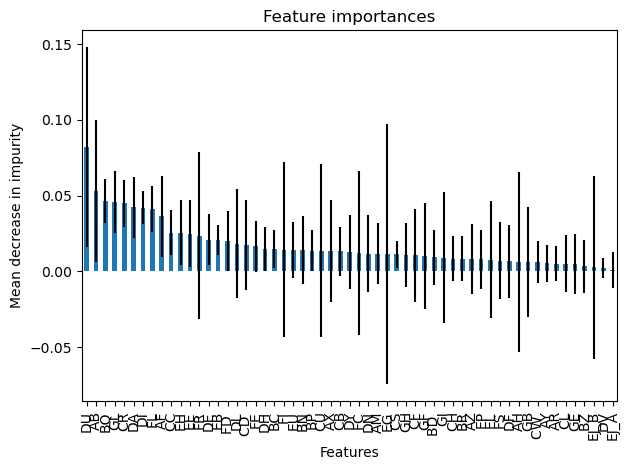

In [23]:
# extract feature importances from the model 
importances = rf_best.feature_importances_

# add standard deviation of feature importance for each feature
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)

# convert importances to pandas series for plotting
forest_importances = pd.Series(importances, index=columns)

#sort in descending order
forest_importances_sorted = forest_importances.sort_values(ascending=False)

# plot 
fig, ax = plt.subplots()
forest_importances_sorted.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xlabel("Features")
fig.tight_layout()

## Check correlation between top 39 variables with highest decrease in impurity 
(This number is given by the number of features that explain 95% of the variance, per PCA. See notebook: `0_sklearn_kfolds_pca.ipynb`)

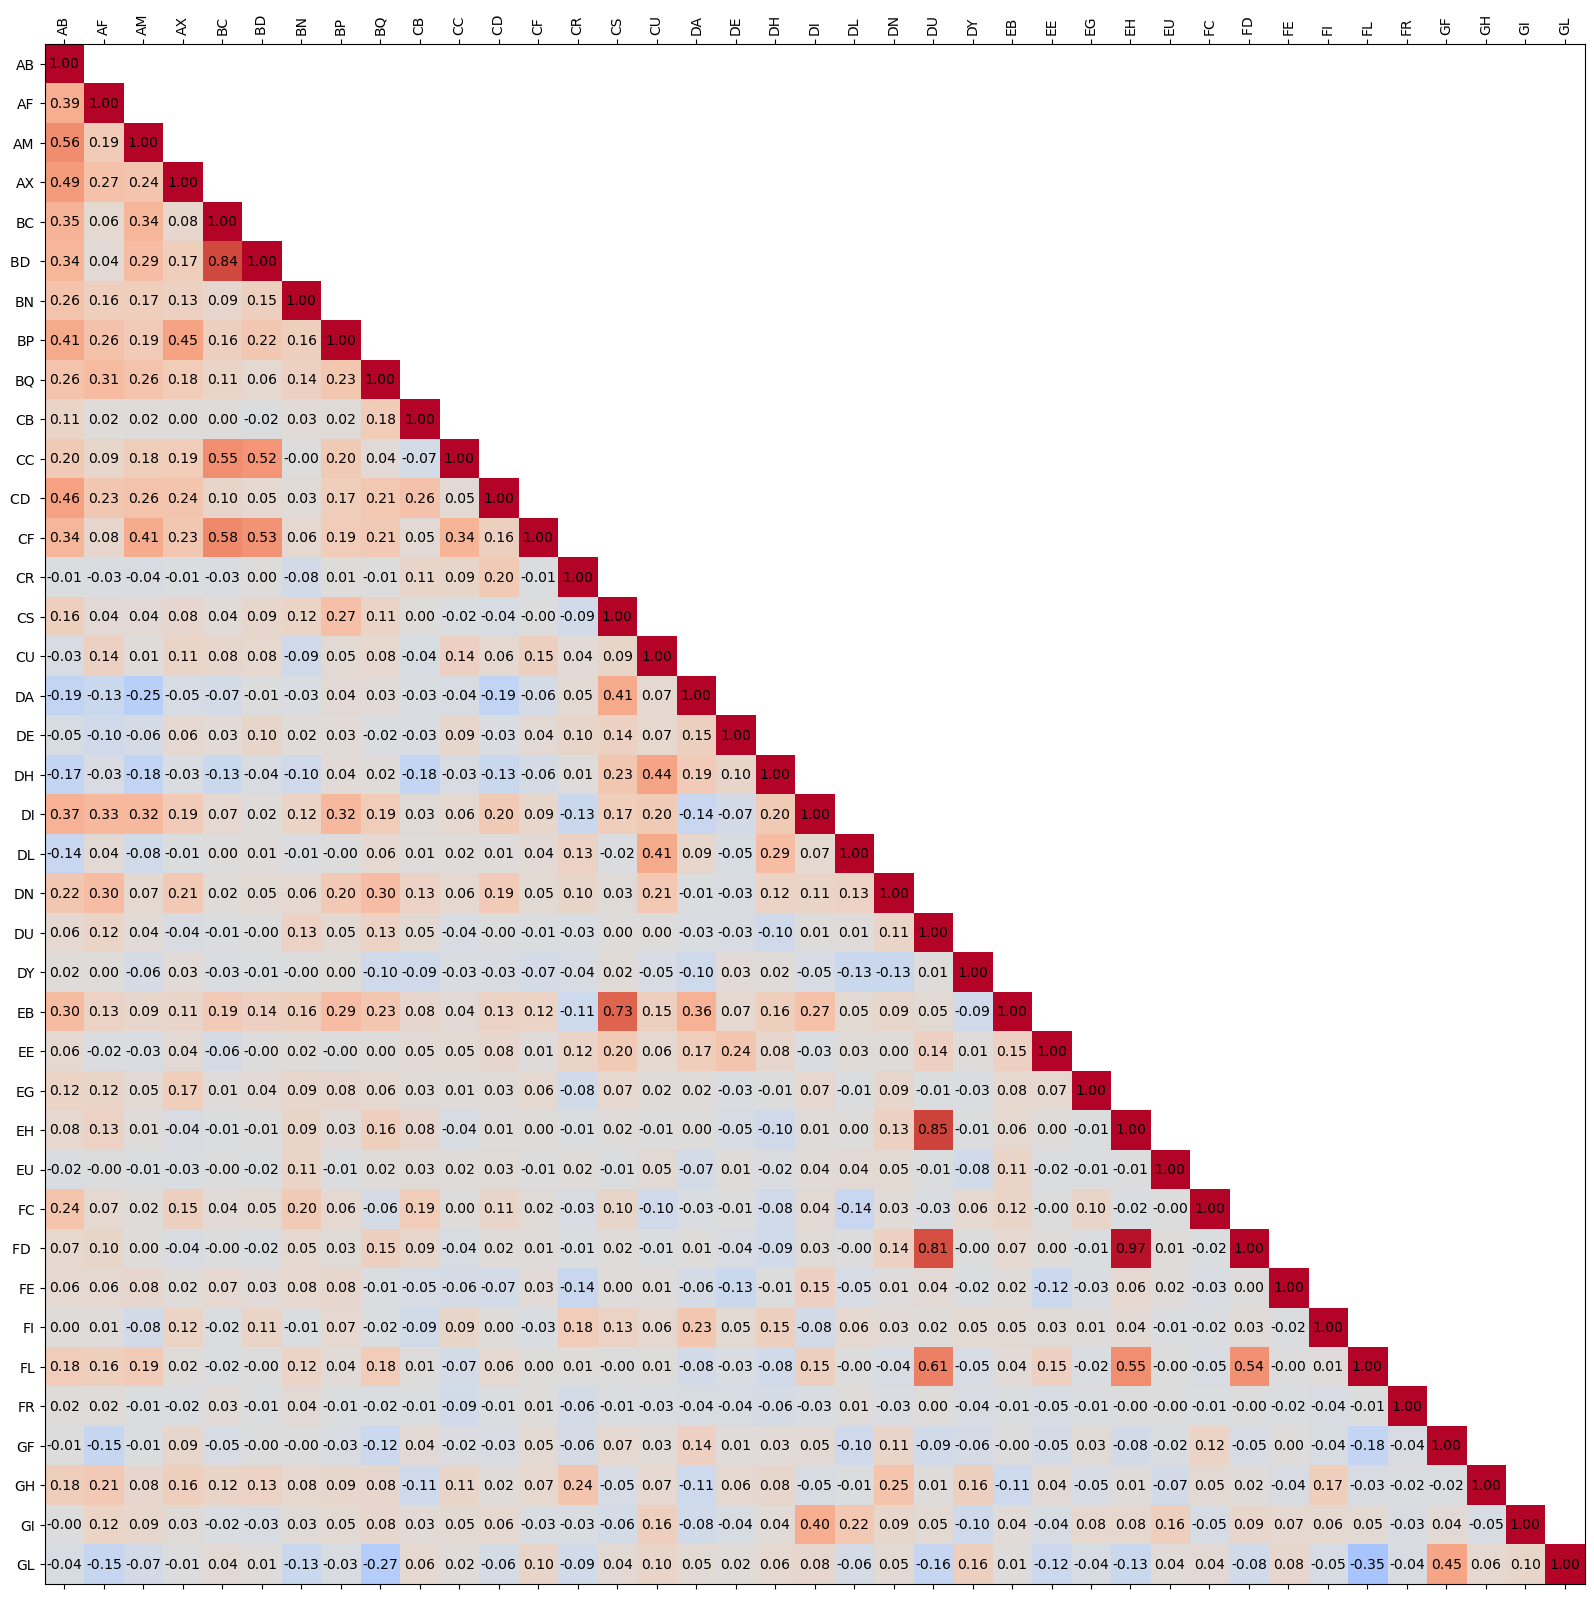

In [24]:
#select top variables
top = forest_importances_sorted[0:39]
df = top.to_frame().reset_index()

# convert into pandas df for correlation
df.columns=['Feature', 'Correlation']
pivot_df = df.pivot_table(index=None, columns='Feature', values='Correlation', aggfunc='mean')

# correlations
FEATURE_COLUMNS = pivot_df.columns
feature_train_df = train_df[FEATURE_COLUMNS]
corr = feature_train_df.corr()

#heatmap 
fig = plt.figure( figsize=(20, 20))
ax = fig.add_subplot(111)

# Create a mask for the upper triangle
mask = np.triu(np.ones(corr.shape), k=1)

# Set the upper triangle of the correlation matrix to white
corr = corr.where(mask == 0)

# Create the heatmap
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

# Plot 
ticks = np.arange(0, len(feature_train_df.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(feature_train_df.columns)
ax.set_yticklabels(feature_train_df.columns)

# Annotate the correlation values on the heatmap
for i in range(len(feature_train_df.columns)):
    for j in range(len(feature_train_df.columns)):
        if mask[i, j] == 0:  # Display text only for the lower triangular part
            text = "{:.2f}".format(corr.iloc[i, j])  # Format the correlation value to two decimal places
            ax.text(j, i, text, ha='center', va='center', color='black')

plt.show()



# Conclusion: which features should be selected?

- The features with the highest decrease in impurity are: DU, AB, BQ, GL, CR, DA, DI, FL, AF, CC, EH, EE, FR, DE, EB, FD, DL, CD, FE, DH, BC, FI, EU, BN, BP, CU, CB, DY, FC, DN, AM, EG, CS, GH, CF, GF, BD, GI
- However, DU is is highly correlated with EH (0.85) FD (0.81) and somewhat with FL (0.61).
- Other correlations: EH and FD are very highly correlated (0.97), CS and EB (0.73).

So it might be a good idea to drop the features which are highly correlated with DU (EH, FD, FL), seeing as DU is the feature with highest decrease in impurity, as well as one of the features in each highly correlated pair (CS/EB).

**Suggested features for input:**
DU, AB, BQ, GL, CR, DA, DI, AF, CC, EE, FR, DE, EB, DL, CD, FE, DH, BC, FI, EU, BN, BP, CU, CB, DY, FC, DN, AM, EG, CS, GH, CF, GF, BD, GI

